In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

π = np.pi

# Rotors

In [2]:
def exp_decay(t, x0, rate):
    x = 1 + (x0 - 1) * np.exp(-rate * t)
    return x


def rand(a, b):
    return a + np.random.random() * (b - a)

In [3]:
class CurveGenerator:
    def __init__(self, **kw):
        
        self.period_min = 150.
        self.period_max = 1000.
        
        self.aperiodicity_max = kw.get("aperiodicity_max", 0.2)
        self.squeeze_max_max = kw.get("squeeze_max_max", 0.5)
        self.squeeze_rate_max = kw.get("squeeze_rate_max", 1.)
        
        self.r_shift_min = 1
        self.r_shift_max = 5
        
        self.n_modes_max = 10
        self.n_period_max = 5
        
        self.Δt = 10.
        
    def __call__(self, n_periods):
                
        period = rand(self.period_min, self.period_max)
        t_max = n_periods * period
        t = np.arange(0, t_max, self.Δt)
        
        ϕ = t / period * 2 * π
        
        r = np.zeros_like(t)
        
        n_mode = np.random.randint(1, self.n_modes_max + 1)
        
        ωs = []
        
        for i in range(n_mode):
            ω = 1 if i == 1 else np.random.randint(1, self.n_period_max + 1)
            ω *= (1 + self.aperiodicity_max * np.random.random())
            ωs.append(ω)
            ϕ0 = np.random.random() * 2 * π

            r_current = np.sin(ω * ϕ + ϕ0)
            r += r_current
            
        r = (r - r.min()) / r.ptp()
        r += rand(self.r_shift_min, self.r_shift_max)
        r /= r.max()
        
        squeeze_rate = rand(0, self.squeeze_rate_max)
        squeeze_max = rand(-self.squeeze_max_max, self.squeeze_max_max)
        
        squeeze = exp_decay(
            ϕ / (2 * π),
            1 + squeeze_max,
            squeeze_rate
        )
        
        # squeeze = (1 - squeeze_max) + squeeze_max * np.exp( * squeeze_rate)
        r *= squeeze
        
        x = r * np.cos(ϕ)
        y = r * np.sin(ϕ)
        
        result = {
            "t": t,
            "ϕ": ϕ,
            "r": r,
            "x": x,
            "y": y,
            "ωs": ωs,
            "period": period,
            "squeeze_rate": squeeze_rate,
            "squeeze_max": squeeze_max
        }   
            
        return result

# Random Walk

In [4]:
def generate_random_walk(n, x0=0.):
    dx = np.random.rand(n) - 0.5
    dx[0] = 0.
    x = x0 + np.cumsum(dx)
    return x


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def generate_random_walk_3d(n, w):
    X = [moving_average(generate_random_walk(n), w) for _ in range(3)]
    X = np.vstack(X).T
    return X


def normalize_path(X):
    v = np.diff(X, axis=0)
    v = v / np.linalg.norm(v, axis=1, keepdims=True)
    return np.cumsum(v, axis=0)


def scale_path(X):
    v = np.diff(X, axis=0)
    v = v / np.linalg.norm(v, axis=1, keepdims=True)
    
    scaler = 1 + 0.5 * np.sin(np.arange(len(v)) * 0.0042)
    v = v * scaler.reshape(v.shape[0], 1)
    
    return np.cumsum(v, axis=0)

# Rotations

In [5]:
def create_rotation_matrix(α, axis):
    S = np.array(
        [[1         , 0        , 0         ],
         [0         , np.cos(α), -np.sin(α)],
         [0         , np.sin(α),  np.cos(α)]]
    )
    
    S = np.roll(S, axis, 0)
    S = np.roll(S, axis, 1)
    
    return S

def create_random_rotation():
    S = np.eye(3)
    for _ in range(10):
        α = rand(0, 2 * π)
        axis = np.random.randint(0, 3)
        S_current = create_rotation_matrix(α, axis)
        S = np.dot(S_current, S)
    return S


def find_rotation_matrix(a, b):

    a_unit = a / np.linalg.norm(a)
    b_unit = b / np.linalg.norm(b)

    ν = np.cross(a_unit, b_unit)
    s = np.linalg.norm(ν)
    c = np.dot(a_unit, b_unit)
    # c = √(1 - s^2)
    
    M = [
        [0,    -ν[2],  ν[1]],
        [ν[2],  0,    -ν[0]],
        [-ν[1],  ν[0],  0]
        ]
    M = np.array(M)
    
    return np.eye(3) + M + np.dot(M, M) * (1 - c) / (s**2)

In [6]:
a = np.array([0, 0, 1])
b = np.array([1, 1, 1])
b = b / np.linalg.norm(b)

S = find_rotation_matrix(a, b)

assert np.allclose(
    np.dot(S, a),
    b
)

# Main

In [24]:
X = generate_random_walk_3d(100, 10)
# X = normalize_path(X)
X = scale_path(X)

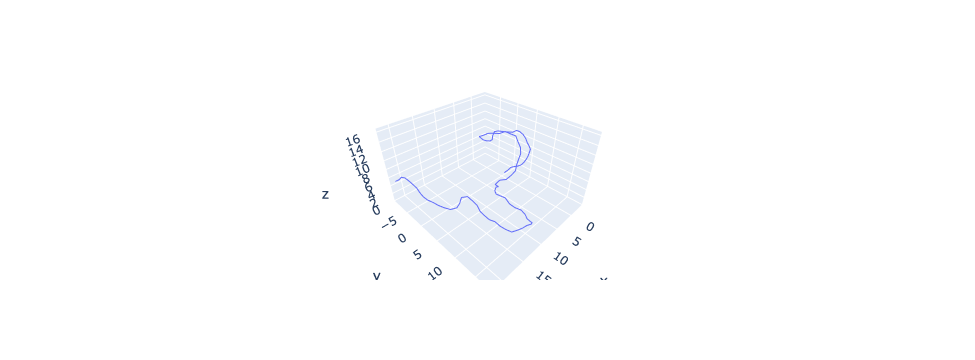

In [25]:
px.line_3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2]
)

In [9]:
curvegen = CurveGenerator()

(-0.8310865110456727,
 0.9270778139172956,
 -0.9282274682600453,
 0.8274275104614254)

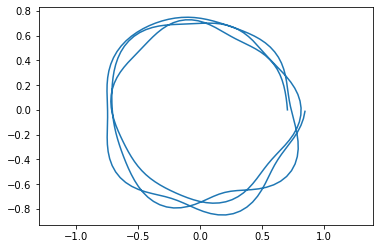

In [10]:
result = curvegen(3)
x = result["x"]
y = result["y"]
plt.plot(x, y)
plt.axis("equal")

In [11]:
result["ωs"]

[2.0180068552853205,
 1.0455575069022056,
 1.085143638050816,
 1.1350223772338581,
 5.548931164970305,
 3.565139022180639,
 4.438817837428955,
 3.0574509207829097,
 4.2677588396568185]

In [12]:
result["squeeze_rate"]

0.3394993196637125

In [13]:
result["squeeze_max"]

-0.2159309996532247

In [14]:
result = curvegen(4.5)

x = result["x"]
y = result["y"]
z = np.zeros_like(x)
period = result["period"]

# z = result["r"]

X = np.vstack([x, y, z]).T
S = create_random_rotation()
X = np.dot(S, X.T).T
# X = normalize_path(X)

In [15]:
result["period"]

871.7489089755946

In [16]:
Z = [X]
probas = [np.full_like(X[1:, 1], period)]

In [17]:
for i in range(1000):

    is_rotor = i % 2
    
    if is_rotor:
        n_periods = rand(0, 0.9) if not is_rotor else rand(1.1, 5.)
        result = curvegen(n_periods)

        x = result["x"]
        y = result["y"]
        period = result["period"]
        
        α = rand(0.5, 1)
        x *= α
        y /= α

        z = np.zeros_like(x)
        X = np.vstack([x, y, z]).T
        S = create_random_rotation()
        X = np.dot(S, X.T).T
        
    else:
        w = 50
        X = generate_random_walk_3d(
            np.random.randint(w + 10, 300),
            w
        )
        period = 0
        
        
    # X = normalize_path(X)

    proba = np.full_like(X[:, 1], period)

    X -= X[0]

    X_last = Z[-1]
    a = X_last[-1] - X_last[-2]
    b = X[1] - X[0]

    S = find_rotation_matrix(b, a)
    X = np.dot(S, X.T).T
    X += X_last[-1]
    Z.append(X[1:])
    probas.append(proba[1:])

In [18]:
X = np.vstack(Z)
X = scale_path(X)

In [19]:
df = pd.DataFrame(X, columns=["x", "y", "z"])
df["period"] = np.hstack(probas)

In [20]:
# filename_save = "../data/synthetic-latest.csv"
# df.to_csv(filename_save, index=False)

# More

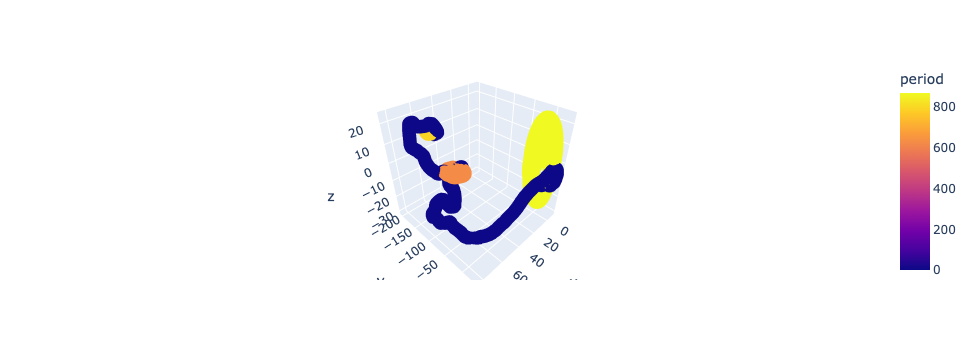

In [21]:
px.scatter_3d(
    df[:1000],
    x = "x",
    y = "y",
    z = "z",
    color = "period"
)

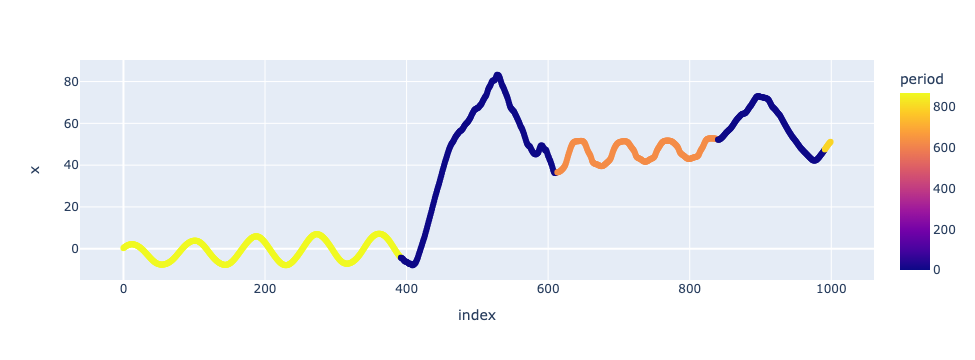

In [22]:
px.scatter(
    df[:1000],
    y="x",
    color="period"
)